In [1]:
import numpy as np
from IPython.display import clear_output, display
import torch
import random
import copy
import time
import os #to get current working directory
import matplotlib.pyplot as plt
import pickle #for storing data
from wurm.envs import SingleSnake
from wurm.envs import SimpleGridworld
from gym.wrappers.monitoring.video_recorder import VideoRecorder

DEFAULT_DEVICE = 'cuda' #set device

## Visualizing the neural network. Requires Tensorboard

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_graph(qnet, torch.Tensor(env.reset()))
writer.close()
%load_ext tensorboard
%tensorboard --logdir=runs

## Replay Buffer

In [414]:
import collections

class ReplayBuffer():
    def __init__(self, max_buffer_size: int):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer = collections.deque(maxlen=max_buffer_size)

    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer.append(data)
        
    #Sample superbatches and sub sample parallel environments
    def sample_subbatch(self,superbatch_length, subbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        sub_length = self.buffer[0][0].shape[0]
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            rand_int_1 = np.random.randint(0, sub_length, subbatch_length)
            transition = self.buffer[rand_int]
            states.append(transition[0][rand_int_1])
            next_states.append(transition[1][rand_int_1])
            actions.append(transition[2][rand_int_1])
            rewards.append(transition[3][rand_int_1])
            terminals.append(transition[4][rand_int_1])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)

    def sample_superbatch(self,superbatch_length):
        states = []
        next_states = []
        actions = []
        rewards = []
        terminals = []
        for rand_int in np.random.randint(0, len(self.buffer), superbatch_length):
            transition = self.buffer[rand_int]
            states.append(transition[0])
            next_states.append(transition[1])
            actions.append(transition[2])
            rewards.append(transition[3])
            terminals.append(transition[4])
        return torch.cat(states), torch.cat(next_states), torch.cat(actions), torch.cat(rewards), torch.cat(terminals)
    
    #sample parallel environments of subbatch_length from a randomly selected buffer location.
    def sample(self, subbatch_length):
            rand_int = np.random.randint(0, len(self.buffer))
            rand_int_1 = np.random.randint(0, len(self.buffer[0][0]), subbatch_length)
            transition = self.buffer[rand_int]
            states=transition[0][rand_int_1]
            next_states=transition[1][rand_int_1]
            actions=transition[2][rand_int_1]
            rewards=transition[3][rand_int_1]
            terminals=transition[4][rand_int_1]
            return (states,next_states,actions,rewards,terminals)

        
#A buffer with lesser correlation between samples. Implemented with pytorch. 
#Presently not working properly. Not sure why.
class BetterBuffer():
    def __init__(self, max_envs: int = 1000):
        #data must be of the form (state,next_state,action,reward,terminal)
        self.buffer_0 = torch.empty(0).to(DEFAULT_DEVICE)
        self.buffer_1 = torch.empty(0).to(DEFAULT_DEVICE)
        self.buffer_2 = torch.empty(0).long().to(DEFAULT_DEVICE)
        self.buffer_3 = torch.empty(0).to(DEFAULT_DEVICE)
        self.buffer_4 = torch.empty(0).bool().to(DEFAULT_DEVICE)
        self.max_length = max_envs
        self.pointer = 0
        self.full = False

    def add_to_buffer(self, data):
        #data must be of the form (state,next_state,action,reward,terminal)
        if self.full == True:
            if self.pointer==self.max_length:
                self.pointer=0
            self.buffer_0[self.pointer*num_envs:(self.pointer+1)*num_envs] = data[0]
            self.buffer_1[self.pointer*num_envs:(self.pointer+1)*num_envs] = data[1]
            self.buffer_2[self.pointer*num_envs:(self.pointer+1)*num_envs] = data[2]
            self.buffer_3[self.pointer*num_envs:(self.pointer+1)*num_envs] = data[3]
            self.buffer_4[self.pointer*num_envs:(self.pointer+1)*num_envs] = data[4]
            self.pointer+=1
        else:
            self.buffer_0=torch.cat((self.buffer_0,data[0]))
            self.buffer_1=torch.cat((self.buffer_1,data[1]))
            self.buffer_2=torch.cat((self.buffer_2,data[2]))
            self.buffer_3=torch.cat((self.buffer_3,data[3]))
            self.buffer_4=torch.cat((self.buffer_4,data[4]))
            self.pointer+=1
            if self.pointer==self.max_length:
                self.full=True
        
    def sample(self, batch_size):
        if self.full == True:
            randint = torch.randint(0, self.max_length*num_envs,(batch_size,))
        else:
            randint = torch.randint(0,self.pointer*num_envs, (batch_size,))
        return self.buffer_0[randint], self.buffer_1[randint], self.buffer_2[randint], self.buffer_3[randint], self.buffer_4[randint]
    

## DQN Agent

In [425]:
#################Simple DQN Agent########################################
class DQNAgent():
    def __init__(self, NN: object, NN_args: tuple = (), 
                 num_envs: int = 1, buffer_size: int = 800, 
                 lr: float = 0.0005, discount: float = 0.8, tau: float = 0.01,
                 lam = 10):
        #self.qnet = torch.load("dqn80x80.h5")
        self.qnet = NN(*NN_args)
        
        self.qnet_target = copy.deepcopy(self.qnet)
        for param in self.qnet_target.parameters():
            param.requires_grad = False
    
        self.qnet_optim = torch.optim.Adam( self.qnet.parameters(), lr=lr) #set learning rate
        self.discount_factor = torch.Tensor([discount]).to(DEFAULT_DEVICE) # set discount factor
        self.MSELoss_function = torch.nn.MSELoss()
        self.replay_buffer = ReplayBuffer(buffer_size) #set size of replay buffer.
        self.old_buffer = ReplayBuffer(300)
        
        self.target_update_interval = 500 #set for target update interval for hard target network updates
        self.update_count= 0 #internal working variable. Don't change
        self.tau = tau # set tau for soft target network updates
        self.num_envs = num_envs
        self.ewc_counter = 0 #flag keep track of fisher matrix computations.
        self.lam = torch.Tensor([lam]).to(DEFAULT_DEVICE)
        self.ewc_on = False
        
    def add_to_buffer(self, data):
        self.replay_buffer.add_to_buffer(data)
    
    #computing diagonal of fisher matrix
    def compute_fisher_diagonal(self, data):
        print("Computing Fisher diagonal...")
        self.params = [p for p in agent.qnet.parameters()]
        self.theta_star = [p.data for p in copy.deepcopy(self.params)]
        matrix = [p.data*0 for p in copy.deepcopy(self.params)]
        
        for st in data:
            agent.qnet.zero_grad()
            output = agent.qnet(st.unsqueeze(0))
            label = output.max(dim=1)[1]
            lsm = torch.nn.functional.log_softmax(output, dim=1)
            loss = torch.nn.functional.nll_loss(lsm, label)
            temp = torch.autograd.grad(loss,self.params)
    
            for n in range(len(matrix)):
                matrix[n]+=temp[n]**2

        for n in range(len(matrix)):
            matrix[n]/=data.shape[0]
        self.fisher = matrix
        print("Computing Fisher diagonal completed.")

    #Computing EWC loss using diagonal of fisher matrix  
    #Based on https://arxiv.org/abs/1612.00796
    def ewc_loss(self):
        loss = 0
        for n in range(len(self.fisher)):
            loss+=(self.fisher[n]*(self.params[n]-self.theta_star[n])**2).sum()
        return loss*self.lam
    
    def train(self):
        self.qnet.train()
        torch.set_grad_enabled(True)
        
    def evaluate(self):
        self.qnet.eval()
        torch.set_grad_enabled(False)
        
    #Hard update target network
    def target_update(self,network,target_network):
        for net_params, target_net_params in zip(network.parameters(), target_network.parameters()):
            target_net_params.data.copy_(net_params.data)
     
    #Soft update target network
    def soft_target_update(self,network,target_network):
        for net_params, target_net_params in zip(network.parameters(), target_network.parameters()):
            target_net_params.data.copy_(net_params.data*self.tau + (1-self.tau)*target_net_params)
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
                return env.random_action()  # choose random action
        else:                
            return torch.argmax(self.qnet(state), dim=1)  # choose greedy action
    
    #update Q Network by calculating gradient of neural network loss
    def update_Q_Network(self, state, next_state, action, reward, terminals):
        qsa = torch.gather(self.qnet(state), dim=1, index=action.unsqueeze(-1)).squeeze()
        qsa_next_action = self.qnet_target(next_state)
        qsa_next_action = torch.max(qsa_next_action, dim=1)[0]
        not_terminals = ~terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qsa_next_action
        
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        #EWC loss
        if self.ewc_on:
            q_network_loss+=self.ewc_loss()

        #Gradient descent
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
     
    #call this to update Q network (train) and then make hard update of target network
    def hard_update(self, update_rate):
        for _ in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample(self.num_envs//3)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
            self.update_count+=1
            if self.update_count==self.target_update_interval:
                self.target_update(self.qnet, self.qnet_target)
                self.update_count=0
                
    #call this to update Q network (train) and then make soft update of target network
    def update(self, update_rate, batch_size = 100):
        if self.ewc_on:
            if self.ewc_counter%(1000*update_rate)==0:
                data = self.replay_buffer.sample_superbatch(3)[0]
                self.compute_fisher_diagonal(data)
            self.ewc_counter+=1
           
        for _ in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample(batch_size)
            self.update_Q_Network(states, next_states, actions, rewards, terminals)
            self.soft_target_update(self.qnet, self.qnet_target)

###############Simple DQN Agent######################################################            

#################Double DQN Agent smooth##############################################
#Based on https://arxiv.org/abs/1509.06461v3
class DDQNAgent_smooth(DQNAgent):
    def __init__(self, NN: object, NN_args: tuple = (), 
                 num_envs: int = 1, buffer_size: int = 800,
                 lr: float = 0.0005, discount: float = 0.8, tau: float = 0.01):
        super().__init__(NN, NN_args, num_envs, buffer_size, lr, discount, tau)
    
    #update Q Network by calculating gradient of neural network loss
    def update_Q_Network(self, state, next_state, action, reward, terminals):
        qsa = torch.gather(self.qnet(state), dim=1, index=action.unsqueeze(-1)).squeeze()
        q_target_next_state_a = self.qnet_target(next_state)
        q_target_next_state_max_a = torch.argmax(q_target_next_state_a, dim=1)
        q_next_state_a = torch.gather(self.qnet(next_state), dim=1, index=q_target_next_state_max_a.unsqueeze(-1)).squeeze()
        not_terminals = ~terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * q_next_state_a
        
        q_network_loss = self.MSELoss_function(qsa, qsa_next_target.detach())
        if self.ewc_on:
          q_network_loss+=self.ewc_loss()
            
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        self.qnet_optim.step()
        
            
#################Double DQN Agent smooth##################################

#################Double DQN Agent########################################
#Based on https://arxiv.org/abs/1509.06461v1
class DDQNAgent(DQNAgent):
    def __init__(self, NN: object, NN_args: tuple = (), 
                 num_envs: int = 1, buffer_size: int = 800,
                 lr: float = 0.0005, discount: float = 0.8):
        #self.qnet = torch.load("dqn80x80.h5")
        self.Q_A = NN(*NN_args)
        self.Q_B = NN(*NN_args)
        self.Q_A_optim = torch.optim.Adam( self.Q_A.parameters(), lr=lr) #set learning rate
        self.Q_B_optim = torch.optim.Adam( self.Q_B.parameters(), lr=lr) #set learning rate
        self.discount_factor = torch.Tensor([discount]).to(DEFAULT_DEVICE) # set discount factor
        self.MSELoss_function = torch.nn.MSELoss()
        self.replay_buffer = ReplayBuffer(buffer_size) #set size of replay buffer.
        self.num_envs = num_envs
        pass
    
    def train(self):
        self.Q_A.train()
        self.Q_A.train()
        torch.set_grad_enabled(True)
        
    def evaluate(self):
        self.Q_A.eval()
        self.Q_B.eval()
        torch.set_grad_enabled(False)
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
                return env.random_action()  # choose random action
        else:                
            return torch.argmax(self.Q_A(state), dim=1)  # choose greedy action
    
    #update Q Network by calculating gradient of neural network loss
    def update_Q_A_Network(self, state, next_state, action, reward, terminals):
        QA_s_a = torch.gather(self.Q_A(state), dim=1, index=action.unsqueeze(-1)).squeeze()
        QA_sn_a = self.Q_A(next_state)
        QA_sn_a_max = torch.argmax(QA_sn_a, dim=1)
        QB_sn_a = torch.gather(self.Q_B(next_state), dim=1, index=QA_sn_a_max.unsqueeze(-1)).squeeze()
        not_terminals = ~terminals
        QA_s_a_target = reward + not_terminals * self.discount_factor * QB_sn_a
        q_network_loss = self.MSELoss_function(QA_s_a, QA_s_a_target.detach())
        self.Q_A_optim.zero_grad()
        q_network_loss.backward()
        self.Q_A_optim.step()
        
    def update_Q_B_Network(self, state, next_state, action, reward, terminals):
        QB_s_a = torch.gather(self.Q_B(state), dim=1, index=action.unsqueeze(-1)).squeeze()
        QB_sn_a = self.Q_B(next_state)
        QB_sn_a_max = torch.argmax(QB_sn_a, dim=1)
        QA_sn_a = torch.gather(self.Q_A(next_state), dim=1, index=QB_sn_a_max.unsqueeze(-1)).squeeze()
        not_terminals = ~terminals
        QB_s_a_target = reward + not_terminals * self.discount_factor * QA_sn_a
        q_network_loss = self.MSELoss_function(QB_s_a, QB_s_a_target.detach())

        self.Q_B_optim.zero_grad()
        q_network_loss.backward()
        self.Q_B_optim.step()
        
    #call this to update Q network (train) and then make soft update of target network
    def update(self, update_rate, batch_size):
        for _ in range(update_rate):
            states, next_states, actions, rewards, terminals = self.replay_buffer.sample(batch_size)
            if np.random.uniform()<0.5:
                self.update_Q_A_Network(states, next_states, actions, rewards, terminals)
            else:
                self.update_Q_B_Network(states, next_states, actions, rewards, terminals)
#################Double DQN Agent##############################################

## Defining Some Neural Networks

In [435]:
# defining a fully connected neural network
def FNN_1(shape, hidden_dim, action_dim):
    flat_shape = np.product(shape) #length of the flattened state
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(flat_shape,hidden_dim),
        #torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim,hidden_dim),
        #torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, action_dim),
         ).to(DEFAULT_DEVICE)
    return model

def CNN_1():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.Dropout(0.1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        torch.nn.AdaptiveMaxPool2d((1,1)),
        torch.nn.Flatten(),
        torch.nn.Linear(128, 128),
        torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 4),
        ).to(DEFAULT_DEVICE)
    return model

def CNN_2():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.Dropout(0.1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        torch.nn.AdaptiveMaxPool2d((1,1)),
        torch.nn.Flatten(),
        torch.nn.Linear(128, 128),
        torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 128),
        torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 4),
        ).to(DEFAULT_DEVICE)
    return model

def CNN_3():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(),
        torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.AdaptiveMaxPool2d((1,1)),
        torch.nn.Flatten(),
        torch.nn.Linear(64, 128),
        #torch.nn.Dropout(0.2),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 4),
        ).to(DEFAULT_DEVICE)
    return model


## Initializing Environment and Agent

In [434]:
environment = 'SingleSnake'
num_envs = 1300 #Number of parallel environments to simulate. Use small value for cpu (eg. 1)
test_num_envs = 100

if environment == 'SimpleGridworld':
    env = SimpleGridworld(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE)
    test_env = SimpleGridworld(num_envs=test_num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    #Effective buffer_size = buffer_size*num_envs
    agent=DDQNAgent_smooth(NN = CNN_1, #NN_args = (state_dim, 512, action_dim),
                           num_envs = num_envs, buffer_size = 600, lr = 0.0005,
                           discount = 0.8, tau =0.01)


elif environment == 'SingleSnake':
    env = SingleSnake(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE)
    test_env = SingleSnake(num_envs=test_num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)

    state = env.reset()
    state_dim = state.shape[1:]
    action_dim = 4

    #Effective buffer_size = buffer_size*num_envs
    agent=DDQNAgent_smooth(NN = CNN_3, num_envs = num_envs, buffer_size = 600, lr = 0.0005, discount = 0.8, tau =0.01)

else:
    raise Exception("Invalid option")
    
agent.train()
print(agent.qnet)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): AdaptiveMaxPool2d(output_size=(1, 1))
  (4): Flatten()
  (5): Linear(in_features=64, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=4, bias=True)
)


In [433]:
%%time
#theta = torch.nn.utils.parameters_to_vector(agent.qnet.parameters())
params = [p for p in agent.qnet.parameters()]
theta_star = [p.data for p in copy.deepcopy(params)]
matrix = [p.data*0 for p in copy.deepcopy(params)]

data = state
for st in data:
    agent.qnet.zero_grad()
    output = agent.qnet(st.unsqueeze(0))
    label = output.max(dim=1)[1]
    lsm = torch.nn.functional.log_softmax(output, dim=1)
    loss = torch.nn.functional.nll_loss(lsm, label)
    temp = torch.autograd.grad(loss,params)
    
    for n in range(len(matrix)):
        matrix[n]+=temp[n]**2
  
for n in range(len(matrix)):
    matrix[n]/=len(data)


Wall time: 3.07 s


## Training

In [436]:
#%%time
render=False
save_model = False
number_of_episodes = 100000
epsilon = 1.0
####Code to compute total reward####

total_reward = torch.zeros(num_envs).to(DEFAULT_DEVICE)
episode_list=[]
fc_list=[] #food collected
best_fc = 0
####Code to compute total reward####

state=env.reset()
agent.train()

#Filling up the buffer
for i in range(30):
    action = agent.epsilon_greedy_action( state , 1.0) #set epsilon
    next_state, reward, terminal, _ = env.step(action)
    agent.add_to_buffer((state,next_state,action,reward,terminal))
    state = next_state


#Learning
for i in range(0,number_of_episodes):
    
    action = agent.epsilon_greedy_action( state , epsilon) #set epsilon
    next_state, reward, terminal, _ = env.step(action)
    agent.add_to_buffer((state,next_state,action,reward,terminal))
    agent.update(update_rate=10, batch_size=400)
    state = next_state
    
    if i%1000==0:
        self.ewc_on=True #Turning on EWC
        self.lam=100 #Setting scalar parameter in EWC loss function
    
    if i==1000:
        epsilon = 0.1
    elif i==3000:
        epsilon = 0.01
    elif i==5000:
        epsilon = 0.001
    elif i==10000:
        epsilon = 0.0001
    elif i==15000:
        epsilon = 0.00001
    elif i==15000:
        epsilon = 0.000001
    
    if render:
        env.render()

    #New code for recording data. Slower but more accurate.
    if (i%100==0):
        agent.evaluate()                        
        t_state = test_env.reset()
        fc_sum = torch.zeros((test_num_envs,)).float().to(DEFAULT_DEVICE) #foot collected
        #hit_terminal = torch.zeros((test_num_envs,)).bool().to(DEFAULT_DEVICE)

        for steps in range(1000): #max steps
            t_action = agent.epsilon_greedy_action( t_state , 0.0)
            t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
            #anything with a positive reward is considered as food.
            fc_sum+=(t_reward>0).float()
            #hit_terminal |= t_terminal
            t_state = t_next_state
            if t_terminal.all():
                break

        t_sum = fc_sum.cpu().numpy()
        t_mean = np.mean(t_sum)
        print('episode:', i)
        print("Completed:", t_terminal.sum().cpu().numpy(), "/", test_num_envs)
        print("Mean, Median, Max, Min, std:", 
              t_mean, 
              np.median(t_sum),
              np.max(t_sum),
              np.min(t_sum),
              np.std(t_sum))
        fc_list.append(t_mean)
        episode_list.append(i)
        plt.plot(episode_list, fc_list)
        plt.show()
        agent.train()
        clear_output(wait=True)
        if t_mean>best_fc:
            best_fc = t_mean
            torch.save(agent.qnet,"models/best_model.h5")
    
if render:    
    env.close()
    
if save_model:
    model = torch.load("best_model.h5")
    with open('models/best_model.pickle', 'wb') as f:
        pickle.dump((model, episode_list,reward_list), f)

KeyboardInterrupt: 

## Storing Data of best model and associated runtime data.

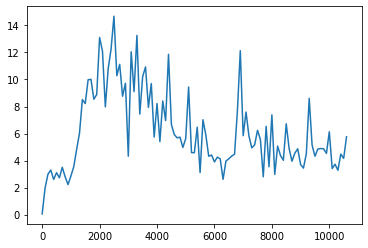

In [437]:
#Visualizing reward
plt.plot(episode_list, fc_list)
plt.show()

#agent.qnet = torch.load("models/bestest_model(1).h5")

In [432]:
list(agent.qnet.parameters())[0].grad

tensor([[[[ 2.1101e-03,  9.7468e-04, -5.7731e-04],
          [ 2.3563e-03,  3.9411e-03,  3.4400e-04],
          [ 4.9174e-03,  2.2736e-03,  3.2663e-03]]],


        [[[-1.0439e-03, -2.0893e-03, -2.1428e-03],
          [-3.2560e-03, -2.2187e-03, -2.7031e-03],
          [ 1.5315e-04,  5.7159e-04, -3.5639e-05]]],


        [[[ 3.5938e-04,  7.2921e-04, -1.1888e-03],
          [-8.2049e-04,  1.7179e-03, -1.2332e-03],
          [ 3.1159e-03,  1.7708e-03,  2.9970e-04]]],


        [[[ 6.4085e-04,  1.4735e-03, -2.3989e-04],
          [-1.0531e-04, -5.3806e-03, -2.3074e-03],
          [-4.6372e-03, -2.0209e-03, -3.9466e-03]]],


        [[[-3.2835e-03, -5.4476e-03, -5.1719e-03],
          [-1.2228e-03, -2.7404e-03, -2.0257e-03],
          [-1.4654e-03, -3.4730e-03, -2.5701e-03]]],


        [[[-1.1047e-03, -2.0111e-03, -2.3322e-03],
          [-2.7463e-04, -2.8320e-03, -2.6048e-03],
          [ 7.8570e-04, -2.8060e-04, -1.4255e-04]]],


        [[[ 2.0956e-03, -2.5859e-03, -3.2625e-03],
       

In [ ]:
#Visualizing reward
plt.plot(episode_list, fc_list)
plt.show()

#Store data about the best model as a pickle file
import pickle
model = torch.load("models/best_model.h5")
with open('models/cnn_256_avg_822.pickle', 'xb') as f:
    pickle.dump((model, episode_list,reward_list), f)

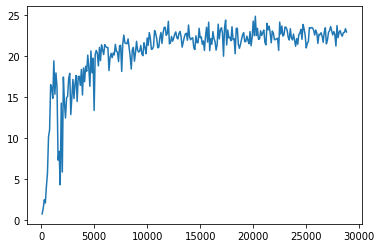

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Dropout(p=0.1, inplace=False)
  (4): ReLU()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Dropout(p=0.2, inplace=False)
  (7): ReLU()
  (8): AdaptiveMaxPool2d(output_size=(1, 1))
  (9): Flatten()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=128, bias=True)
  (14): Dropout(p=0.5, inplace=False)
  (15): ReLU()
  (16): Linear(in_features=128, out_features=4, bias=True)
)


In [35]:
#to load the saved model
with open('models/bestest_model.pickle', 'rb') as f:
     data = pickle.load(f)

model = data[0].to(DEFAULT_DEVICE)        
agent.qnet= data[0]

plt.plot(data[1], data[2])
plt.show()
print(model)

In [ ]:
agent.qnet = torch.load("models/best_model.h5")

## Visualize and Record Gameplay

In [34]:
%%time
env = SingleSnake(num_envs=1, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE)
agent.evaluate()
PATH = os.getcwd()
state = env.reset()
for episode in range(100):
    fc_sum = 0
    recorder = VideoRecorder(env, path=PATH + f'/videos/snake_{episode}.mp4')
    #env.render()
    recorder.capture_frame()
    time.sleep(0.2)
    counter = 0
    while(1):
        counter+=1
        action = agent.epsilon_greedy_action( state , 0.0)
        next_state, reward, terminal, _ = env.step(action)
        fc_sum+= (reward>0).cpu().numpy()
        #env.render()
        recorder.capture_frame()
        #time.sleep(0.2)
        state = next_state
        if terminal.all() or counter==1000:
            recorder.close()
            break
    print("Completed:", terminal.any().cpu().numpy())
    print('episode:', episode, 'Food Collected:', fc_sum)

#env.close()

Completed: True
episode: 0 Food Collected: [12]
Completed: True
episode: 1 Food Collected: [18]
Completed: True
episode: 2 Food Collected: [22]
Completed: True
episode: 3 Food Collected: [18]
Completed: True
episode: 4 Food Collected: [19]
Completed: True
episode: 5 Food Collected: [25]
Completed: True
episode: 6 Food Collected: [33]
Completed: True
episode: 7 Food Collected: [24]
Completed: True
episode: 8 Food Collected: [24]
Completed: True
episode: 9 Food Collected: [22]
Completed: True
episode: 10 Food Collected: [20]
Completed: True
episode: 11 Food Collected: [22]
Completed: True
episode: 12 Food Collected: [21]
Completed: True
episode: 13 Food Collected: [24]
Completed: True
episode: 14 Food Collected: [23]
Completed: True
episode: 15 Food Collected: [16]
Completed: True
episode: 16 Food Collected: [13]
Completed: True
episode: 17 Food Collected: [16]
Completed: True
episode: 18 Food Collected: [21]
Completed: True
episode: 19 Food Collected: [19]
Completed: True
episode: 20 Fo

In [10]:
recorder.close()
env.close()

AttributeError: 'NoneType' object has no attribute 'window'

## Computing Average Return

In [37]:
test_env = SimpleGridworld(num_envs=num_envs, size=10, observation_mode='one_channel', device= DEFAULT_DEVICE, auto_reset=False)
agent.evaluate()

                       
t_state = test_env.reset()
fc_sum = torch.zeros((num_envs,)).float().to(DEFAULT_DEVICE) #foot collected

for steps in range(1000): #max steps
    t_action = agent.epsilon_greedy_action( t_state , 0.0)
    t_next_state, t_reward, t_terminal, _ = test_env.step(t_action)
    #anything with a positive reward is considered as food.
    fc_sum+=(t_reward>0).float()
    t_state = t_next_state
    if t_terminal.all():
        break

t_sum = fc_sum.cpu().numpy()
t_mean = np.mean(t_sum)
print("Completed:", t_terminal.sum().cpu().numpy())
print("Mean, Median, Max, Min, std:", 
      t_mean, 
      np.median(t_sum),
      np.max(t_sum),
      np.min(t_sum),
      np.std(t_sum))

Completed: 1280
Mean, Median, Max, Min, std: 0.053076923 0.0 1.0 0.0 0.22418688
